In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/LAB_mod_B/Project
#import sys
#print(sys.executable)

Mounted at /content/drive


# Overview

Our VAE will have Gaussian Latent variables and a Gaussian Posterior distribution $q_\phi({\mathbf z}|{\mathbf x})$ with a diagonal covariance matrix.

Recall, that a VAE consists of four essential elements:

* A latent variable ${\mathbf z}$ drawn from a distribution $p({\mathbf z})$ which in our case will be a Gaussian with mean zero and standard
deviation $\epsilon$.
* A decoder $p(\mathbf{x}|\mathbf{z})$ that maps latent variables ${\mathbf z}$ to visible variables ${\mathbf x}$. In our case, this is just a Multi-Layer Perceptron (MLP) - a neural network with one hidden layer.
* An encoder $q_\phi(\mathbf{z}|\mathbf{x})$ that maps examples to the latent space. In our case, this map is just a Gaussian with means and variances that depend on the input: $q_\phi({\bf z}|{\bf x})= \mathcal{N}({\bf z}, \boldsymbol{\mu}({\bf x}), \mathrm{diag}(\boldsymbol{\sigma}^2({\bf x})))$
* A cost function consisting of two terms: the reconstruction error and an additional regularization term that minimizes the KL-divergence between the variational and true encoders. Mathematically, the reconstruction error is just the cross-entropy between the samples and their reconstructions. The KL-divergence term can be calculated analytically for this term and can be written as

$$-D_{KL}(q_\phi({\bf z}|{\bf x})|p({\bf z}))={1 \over 2} \sum_{j=1}^J \left (1+\log{\sigma_j^2({\bf x})}-\mu_j^2({\bf x}) -\sigma_j^2({\bf x})\right).
$$

# Importing libraries

In [5]:
# for the model
import torch
from torch import nn

# for the train
import torch
import torchvision.datasets as datasets    # for the MNIST data
from tqdm import tqdm                      # for a progress bar
from torch import nn, optim                # for neural networks
from torchvision import transforms         # for image augmentation
from torchvision.utils import save_image   # to view the images
from torch.utils.data import DataLoader    # easier dataset managment

import matplotlib.pyplot as plt

# Model Definition

In [6]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, h_dim=200, z_dim=20):       # hidden dim and z dim
        super().__init__()
        # encoder
        self.img_2hid = nn.Linear(input_dim, h_dim)           # input -> hidden dim
        self.hid_2mu = nn.Linear(h_dim, z_dim)                # hidden dim -> mean
        self.hid_2sigma = nn.Linear(h_dim, z_dim)             # hidden dim -> std

        # decoder
        self.z_2hid = nn.Linear(z_dim, h_dim)                 # latent -> hidden dim
        self.hid_2img = nn.Linear(h_dim, input_dim)           # hidden dim -> input dim

        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.img_2hid(x))
        mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
        return mu, sigma

    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))                 # !! sigmoid for normalized input

    def forward(self, x):                                      # to connect encoder and decoder
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)                      # reparameterization trick
        z_new = mu + sigma*epsilon
        x_reconstructed = self.decode(z_new)
        return x_reconstructed, mu, sigma                      # x_rec is for the rec_loss and mu,sigma for the KL_div (and also for our NN)


if __name__ == "__main__":
    x = torch.randn(4, 28*28)                                   # 4 is the batch_size, 28*28 is the input dim
    vae = VariationalAutoEncoder(input_dim=784)                 # also here input_dim
    x_reconstructed, mu, sigma = vae(x)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


# Training Process

The hyperparameters we need to specify the architecture and train the VAE are:

* The dimension of the hidden layers for encoders and decoders (`h_dim`)
* The dimension of the latent space (`z_dim`)
* Optimization hyper-parameters: `BATCH_SIZE`, `NUM_EPOCHS`

In [18]:
from model import VariationalAutoEncoder


# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 784           # input dim
H_DIM = 200               # hidden dim
Z_DIM = 20                # latent dim: 2 - 100
NUM_EPOCHS = 20
BATCH_SIZE = 128          # 64 - 128 (32 va un po' male)
LR_RATE = 1e-3            # 3e-4   Karpathy constant

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten to 784
])

# Dataset Loading
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")     # try with different loss

# to visualize the average loss per epoch
history = {
    'total_loss': [],
    'reconstruction_loss': [],
    'kl_div': []
}

# Start training
for epoch in range(NUM_EPOCHS):

  epoch_total = 0
  epoch_recon = 0
  epoch_kl = 0
  num_samples = 0

  model.train()
  loop = tqdm(enumerate(train_loader))

  for i, (x, _) in loop:
    # Forward pass
    x = x.to(DEVICE).view(x.shape[0], INPUT_DIM)
    x_reconstructed, mu, sigma = model(x)

    # Loss Function
    reconstruction_loss = loss_fn(x_reconstructed, x)
    #kl_div = -0.5 * torch.sum(1 + torch.log(sigma.pow(2) + 1e-8) - mu.pow(2) - sigma.pow(2))
    logvar = torch.log(sigma.pow(2) + 1e-8)                                                      # più stabile
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    loss = reconstruction_loss + kl_div

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_postfix(
        total_loss=loss.item() / x.shape[0],
        reconstruction_loss=reconstruction_loss.item() / x.shape[0],
        kl_div=kl_div.item() / x.shape[0])

    # Accumulate per epoch
    epoch_total += loss.item()
    epoch_recon += reconstruction_loss.item()
    epoch_kl += kl_div.item()
    num_samples += x.shape[0]

  # Compute and store averages after each epoch
  history['total_loss'].append(epoch_total / num_samples)
  history['reconstruction_loss'].append(epoch_recon / num_samples)
  history['kl_div'].append(epoch_kl / num_samples)

469it [00:15, 29.80it/s, kl_div=17.1, reconstruction_loss=124, total_loss=141]
469it [00:16, 28.57it/s, kl_div=21.1, reconstruction_loss=111, total_loss=133]
469it [00:16, 28.41it/s, kl_div=23, reconstruction_loss=102, total_loss=125]
469it [00:15, 29.38it/s, kl_div=23.9, reconstruction_loss=91.8, total_loss=116]
469it [00:15, 29.77it/s, kl_div=23.5, reconstruction_loss=92.4, total_loss=116]
469it [00:15, 29.61it/s, kl_div=23.7, reconstruction_loss=84.6, total_loss=108]
469it [00:15, 29.42it/s, kl_div=23.9, reconstruction_loss=85.8, total_loss=110]
469it [00:15, 29.38it/s, kl_div=23.8, reconstruction_loss=84.5, total_loss=108]
469it [00:16, 28.19it/s, kl_div=24.6, reconstruction_loss=89.3, total_loss=114]
469it [00:16, 28.88it/s, kl_div=25, reconstruction_loss=83.5, total_loss=109]
469it [00:15, 29.54it/s, kl_div=24.4, reconstruction_loss=83.1, total_loss=107]
469it [00:15, 29.39it/s, kl_div=24.5, reconstruction_loss=81.1, total_loss=106]
469it [00:16, 29.26it/s, kl_div=23.5, reconstru

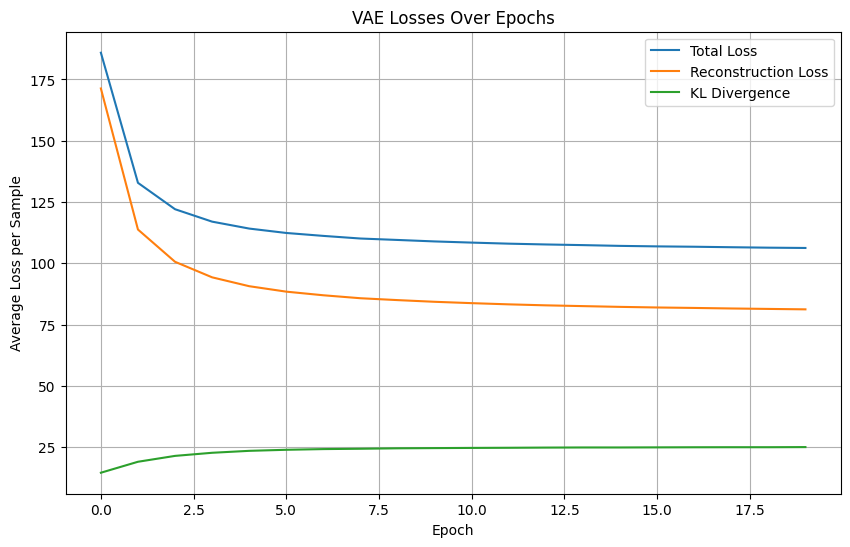

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(history['total_loss'], label='Total Loss')
plt.plot(history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history['kl_div'], label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Average Loss per Sample')
plt.title('VAE Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Questa parte che segue non ci serve

In [ ]:
def inference(digit, num_examples=1):
    """
    Generates (num_examples) of a particular digit.
    Specifically we extract an example of each digit,
    then after we have the mu, sigma representation for
    each digit we can sample from that.

    After we sample we can run the decoder part of the VAE
    and generate examples.
    """
    images = []
    idx = 0
    for x, y in dataset:
        if y == idx:
            images.append(x)
            idx += 1
        if idx == 10:
            break

    encodings_digit = []
    for d in range(10):
        with torch.no_grad():
            mu, sigma = model.encode(images[d].view(1, 784))
        encodings_digit.append((mu, sigma))

    mu, sigma = encodings_digit[digit]
    for example in range(num_examples):
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        out = model.decode(z)
        out = out.view(-1, 1, 28, 28)
        save_image(out, f"generated_{digit}_ex{example}.png")

for idx in range(10):
    inference(idx, num_examples=5)